In [12]:
import pandas as pd
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [13]:
weekly_sales_segmented = pickle.load(open("data/weekly_sales_segmented.pkl", "rb"))
weekly_sales_segmented

,week,cluster,client_size,prediction_CRFNR,prediction_CRFR,prediction_SFNR,prediction_SFR,sold_CRFNR,sold_CRFR,sold_SFNR,...,hdd_week,temp_precip_interaction,temp_first_last_diff,temp_max_jump,temp_volatility_index,temp_increase_days,temp_drop_days,temp_trend,temp_reversal,heat_wave_start
0,202401,0,Pequeno,715.65,1227.05,94.43,0.00,701.37,1171.96,237.90,...,31.252525,12.791246,-0.166667,1.371212,0.755556,1.704545,1.986364,-0.080952,0.204545,0.0
1,202401,0,Mediano,3853.89,7140.45,763.03,6.34,3274.84,6280.20,967.11,...,29.928432,13.011928,-0.232526,1.329713,0.741019,1.744361,1.979950,-0.113816,0.248120,0.0
2,202401,0,Grande,2017.51,3796.23,449.61,0.00,1745.25,3006.84,539.02,...,29.974697,13.004217,-0.308031,1.375138,0.774477,1.752475,2.000000,-0.128713,0.267327,0.0
3,202401,0,Muy Grande,2911.74,5604.44,656.10,0.00,2295.73,4887.59,652.45,...,31.431373,12.761438,-0.383987,1.397059,0.779412,1.676471,2.000000,-0.127918,0.352941,0.0
4,202401,4,Pequeno,391.06,468.28,35.12,3.17,296.87,383.77,57.42,...,21.166028,9.833972,-2.126437,3.422733,1.893997,1.632184,2.816092,-0.354315,0.885057,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,202452,4,Muy Grande,3747.11,4178.02,412.63,55.27,5374.01,4598.67,1026.43,...,1.427702,17.657069,-0.646880,1.590563,0.768645,2.328767,1.794521,-0.091542,-0.260274,0.0
620,202452,5,Pequeno,143.00,244.93,0.00,0.00,296.57,245.37,44.00,...,1.487179,18.757123,-2.606838,1.559829,0.717949,0.730769,2.461538,-0.595849,0.730769,0.0
621,202452,5,Mediano,1039.79,1496.49,34.17,7.04,1683.50,1653.17,210.46,...,1.105072,18.779187,-2.192029,1.364734,0.636473,0.804348,2.434783,-0.509834,0.717391,0.0
622,202452,5,Grande,743.22,1081.54,58.13,3.52,976.05,901.90,167.66,...,1.533333,18.759259,-2.685185,1.537037,0.700000,0.666667,2.400000,-0.607407,0.700000,0.0


In [ ]:
def base_model_OOT(df, pred_col, sold_col, cluster, client_size, temp_col):

    """

    Ajusta las predicciones por rango de temperatura usando una validación OOT 80/20
    (Out-of-Time) basado en la dimensión 'week', filtrando por segmento (Cluster + Tamaño)
   
    Devuelve:
        - resumen de errores OOT
        - dataframe con los factores de ajuste calculados en el 80% de training
    """

    # Copiar y filtrar por Segmento (Cluster + Tamaño)
    data = df.copy()
    if cluster is not None:
        data = data[data["cluster"] == cluster]

    if client_size is not None:
        data = data[data["client_size"] == client_size]

    if data.empty:
        return None

    # Filtrar temperaturas razonables y ordenar por 'week'
    data = data.loc[(data[temp_col] > -10) & (data[temp_col] < 50)].copy()
    data = data.sort_values("week").reset_index(drop=True)

    # Definición del Split OOT (80% Training / 20% Test)
    semanas = sorted(data["week"].unique())
    n_semanas = len(semanas)

    # Fijo 80% para Training y el resto para Test
    split_point_index = int(n_semanas * 0.8)
    train_weeks = semanas[:split_point_index]
    test_weeks = semanas[split_point_index:]

    if not train_weeks or not test_weeks:
        return None

    train = data[data["week"].isin(train_weeks)].copy()
    test = data[data["week"].isin(test_weeks)].copy()
    if train.empty or test.empty:
        return None

    # Calcular factores por rango de temperatura (usando el 80% TRAINING)
    rangos = [(i, i+5) for i in range(-12, 56, 4)]
    ajustes = []

    for t_min, t_max in rangos:
        subset = train[(train[temp_col] >= t_min) & (train[temp_col] < t_max)]

        if len(subset) > 0 and subset[pred_col].sum() != 0:

            # Factor de Ajuste Volumétrico
            factor = subset[sold_col].sum() / subset[pred_col].sum()

            # Guardamos el factor
            ajustes.append({
                "cluster": cluster,
                "client_size": client_size,
                "rango": f"{t_min}-{t_max}",
                "t_min": t_min,
                "t_max": t_max,
                "factor": factor
            })

    ajustes_df = pd.DataFrame(ajustes)

    # Aplicar factores al 20% TEST (OOT)
    def aplicar_factor_oot(row, ajustes_df, temp_col):

        temp = row[temp_col]
        pred = row[pred_col]

        for _, adj_row in ajustes_df.iterrows():
            if adj_row["t_min"] <= temp < adj_row["t_max"]:
                return pred * adj_row["factor"]
        return pred

    test["pred_ajustada"] = test.apply(
        lambda x: aplicar_factor_oot(x, ajustes_df, temp_col),
        axis=1)

    # Calcular Errores OOT
    error_ori_total = (test[sold_col] - test[pred_col]).abs().sum().round(2)
    error_new_total = (test[sold_col] - test["pred_ajustada"]).abs().sum().round(2)

    if error_ori_total == 0:
        mejora = 0

    else:
        mejora = (100 * (error_ori_total - error_new_total) / error_ori_total).round(2)


    return {

        "producto": pred_col,
        "cluster": cluster,
        "client_size": client_size,
        "temp_col": temp_col,
        "error_original": error_ori_total,
        "error_ajustado": error_new_total,
        "mejora_%": mejora,
        "factores": ajustes_df
    }

In [ ]:
# Función para hacer gridsearch para encontrar la configuración que optimice los resultados
def grid_search_OOT(df, pred_col, sold_col, clusters, client_sizes, temp_cols):
    
    resultados = []
    
    for cluster_id in clusters:
        for size_category in client_sizes:
            for temp_col in temp_cols:
                
                try:
                    # Llama a la función OOT
                    res = base_model_OOT(
                        df=df,
                        pred_col=pred_col,
                        sold_col=sold_col,
                        cluster=cluster_id,
                        client_size=size_category,
                        temp_col=temp_col
                    )
    
                    if res is not None:
                        resultados.append(res)
    
                except Exception as e:
                    print(f"Error en combinación {cluster_id}, {size_category}, {temp_col}: {e}")

    return pd.DataFrame(resultados)

In [16]:
products = ["crfnr", "crfr", "sfnr", "sfr"]

clusters = [0, 4, 5]

client_sizes = ['Pequeno', 'Mediano', 'Grande', 'Muy Grande']

temp_cols = ['temp_mean_week', 'temp_std_week', 'temp_max_week',
       'temp_min_week', 'temp_range_mean', 'days_above_30',
       'precip_total_week', 'rain_days', 'cdd_week', 'hdd_week',
       'temp_precip_interaction', 'temp_first_last_diff', 'temp_max_jump',
       'temp_volatility_index', 'temp_increase_days', 'temp_drop_days',
       'temp_trend', 'temp_reversal', 'heat_wave_start']

resultados_best_dict = {}

for product in products:
    for cluster_id in clusters:
        for size_category in client_sizes:
            
            segment_key = f"{product}_{cluster_id}_{size_category}"
            
            # Ejecutar el Grid Search para un solo segmento 
            
            try:
                df_results_segment = grid_search_OOT(
                    df=weekly_sales_segmented,
                    pred_col=f"prediction_{product.upper()}",
                    sold_col=f"sold_{product.upper()}",
                    clusters=[cluster_id],        
                    client_sizes=[size_category], 
                    temp_cols=temp_cols
                )
            except Exception as e:
                print(f"Error al correr Grid Search para {segment_key}: {e}")
                continue

            # Registrar la mejor configuración
            
            if df_results_segment.empty:
                continue

            # Encontrar la fila con el valor máximo en "mejora_%"
            best_row = df_results_segment.loc[df_results_segment["mejora_%"].idxmax()].copy()
            
            # Procesar el factor de ajuste
            if "factores" in best_row and isinstance(best_row["factores"], pd.DataFrame):
                factores_df = best_row["factores"]

                factores_consolidated = factores_df.groupby([
                    "cluster", 
                    "client_size", 
                    "rango", 
                    "t_min", 
                    "t_max"
                ])["factor"].mean().reset_index()

                best_row["factores"] = factores_consolidated

            # Guardar la fila óptima en el diccionario
            resultados_best_dict[segment_key] = best_row
            
            print(f"Segmento {segment_key} procesado. Mejora máxima: {best_row['mejora_%']}%")

Segmento crfnr_0_Pequeno procesado. Mejora máxima: 63.97%
Segmento crfnr_0_Mediano procesado. Mejora máxima: 34.44%
Segmento crfnr_0_Grande procesado. Mejora máxima: 21.71%
Segmento crfnr_0_Muy Grande procesado. Mejora máxima: 24.61%
Segmento crfnr_4_Pequeno procesado. Mejora máxima: 25.38%
Segmento crfnr_4_Mediano procesado. Mejora máxima: 27.58%
Segmento crfnr_4_Grande procesado. Mejora máxima: -17.28%
Segmento crfnr_4_Muy Grande procesado. Mejora máxima: 15.37%
Segmento crfnr_5_Pequeno procesado. Mejora máxima: 49.17%
Segmento crfnr_5_Mediano procesado. Mejora máxima: 33.39%
Segmento crfnr_5_Grande procesado. Mejora máxima: 6.4%
Segmento crfnr_5_Muy Grande procesado. Mejora máxima: 5.98%
Segmento crfr_0_Pequeno procesado. Mejora máxima: 57.64%
Segmento crfr_0_Mediano procesado. Mejora máxima: 12.41%
Segmento crfr_0_Grande procesado. Mejora máxima: 6.63%
Segmento crfr_0_Muy Grande procesado. Mejora máxima: 5.36%
Segmento crfr_4_Pequeno procesado. Mejora máxima: -0.53%
Segmento crfr_4

In [ ]:
# Carga de datos a nivel cliente
weekly_sales_customer = pickle.load(open("data/sales_data_f2.pkl", "rb"))
weekly_sales_customer

,customer_id,week,prediction_CRFNR,prediction_CRFR,prediction_SFNR,prediction_SFR,sold_CRFNR,sold_CRFR,sold_SFNR,sold_SFR,...,temp_first_last_diff,temp_max_jump,temp_volatility_index,temp_increase_days,temp_drop_days,temp_trend,temp_reversal,heat_wave_start,total_sold_week,client_size
0,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,202401,8.63,34.52,6.34,0.0,0.00,33.46,1.41,0.00,...,0.000000,1.111111,0.666667,2,2,-0.142857,0.0,0,34.87,Grande
1,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,202402,6.52,33.64,4.93,0.0,8.98,39.19,4.23,0.00,...,0.555556,1.111111,0.777778,3,2,0.142857,-1.0,0,52.40,Grande
2,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,202403,8.37,34.52,4.93,0.0,11.62,40.16,8.45,0.00,...,0.555556,1.111111,0.777778,3,2,0.142857,-1.0,0,60.23,Grande
3,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,202404,8.72,32.58,2.11,0.0,11.62,39.10,4.23,0.00,...,-1.111111,0.555556,0.222222,0,2,-0.206349,1.0,0,54.95,Grande
4,0066c9224e55b41e3d79e1b494bb34b863859c3d476ff2...,202405,10.30,32.58,4.93,0.0,8.98,37.69,9.86,0.00,...,-2.222222,1.666667,0.888889,2,3,-0.492063,1.0,0,56.53,Grande
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74771,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202448,16.56,8.81,0.00,0.0,15.15,3.17,0.00,0.00,...,-1.666667,1.666667,0.777778,1,2,-0.349206,1.0,0,18.32,Mediano
74772,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202449,16.56,9.86,0.00,0.0,25.01,9.86,0.00,2.11,...,-0.555556,0.555556,0.111111,0,1,-0.079365,1.0,0,36.98,Mediano
74773,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202450,17.61,9.86,0.00,0.0,21.49,3.17,13.03,0.00,...,-0.555556,1.111111,0.555556,1,2,-0.142857,1.0,0,37.69,Mediano
74774,ffed8a62de208d58e9b1c5b6f29fee28608b3f0b2e44d5...,202451,21.13,9.86,0.00,0.0,16.91,13.39,0.00,0.00,...,-2.222222,1.111111,0.444444,0,3,-0.412698,1.0,0,30.30,Mediano


In [ ]:
def get_factor(product, cluster, client_size, temp_value):
    key = f"{product}_{cluster}_{client_size}"

    if key not in resultados_best_dict:
        return 1.0  # Si no hay configuración para este segmento, no ajustar

    info = resultados_best_dict[key]
    factores_df = info["factores"]

    # Buscar el rango donde cae el valor de la columna climática óptima
    fila = factores_df[(temp_value >= factores_df["t_min"]) & 
                       (temp_value < factores_df["t_max"])]

    if len(fila) == 0:
        return 1.0  # Si está fuera de los bins de temperatura, no ajustar

    # Devolver el factor correspondiente a ese bin
    return float(fila["factor"].values[0])

In [ ]:
product_map = {
    "CRFNR": "crfnr",
    "CRFR": "crfr",
    "SFNR": "sfnr",
    "SFR": "sfr"
}

sales = weekly_sales_customer.copy()

# Loop principal para aplicar el ajuste por cada producto
for col in ["CRFNR", "CRFR", "SFNR", "SFR"]:
    product_key = product_map[col]

    # Aplicar el factor segmentado a la columna de predicción
    sales[f"prediction_{col}_adj"] = sales.apply(
        lambda row: row[f"prediction_{col}"] *
                    get_factor(
                        product=product_key,
                        cluster=row["cluster"],
                        client_size=row["client_size"], 
                        temp_value=row[
                            resultados_best_dict[
                                f"{product_key}_{row['cluster']}_{row['client_size']}"
                            ]["temp_col"] 
                        ]
                    ),
        axis=1
    )

In [ ]:
def evaluar_por_segmento_final(df, products):
    rows = []

    for prod in products:
        sold = f"sold_{prod.upper()}"
        pred = f"prediction_{prod.upper()}"
        pred_adj = f"prediction_{prod.upper()}_adj"

        if sold not in df.columns or pred not in df.columns or pred_adj not in df.columns:
            continue

        # Calcular errores a nivel de fila antes de la agregación
        tmp = df.copy()
        tmp["error_orig"] = (tmp[sold] - tmp[pred]).abs()
        tmp["error_adj"] = (tmp[sold] - tmp[pred_adj]).abs()
        tmp["mejora_abs"] = tmp["error_orig"] - tmp["error_adj"]
        tmp["mejora_pct"] = tmp["mejora_abs"] / tmp["error_orig"].replace(0, np.nan) 

        # Agrupar por cluster y tamaño de cliente
        res = tmp.groupby(['cluster', 'client_size']).agg(
            error_original_total=("error_orig", "sum"),
            error_ajustado_total=("error_adj", "sum"),
            mejora_absoluta_total=("mejora_abs", "sum"),
            mejora_pct_promedio=("mejora_pct", "mean") 
        )

        res["producto"] = prod.upper()
        rows.append(res.reset_index())

    return pd.concat(rows, ignore_index=True)

In [22]:
products_to_evaluate = ["CRFNR", "CRFR", "SFNR", "SFR"]

df_resultados_final = evaluar_por_segmento_final(sales, products_to_evaluate)

C:\Users\sofia\AppData\Local\Temp\ipykernel_23568\169101018.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res = tmp.groupby(['cluster', 'client_size']).agg(
C:\Users\sofia\AppData\Local\Temp\ipykernel_23568\169101018.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res = tmp.groupby(['cluster', 'client_size']).agg(
C:\Users\sofia\AppData\Local\Temp\ipykernel_23568\169101018.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence

In [23]:
df_resultados_final

,cluster,client_size,error_original_total,error_ajustado_total,mejora_absoluta_total,mejora_pct_promedio,producto
0,0,Pequeno,29030.85,32445.823918,-3414.973918,-0.673206,CRFNR
1,0,Mediano,105574.74,108681.951026,-3107.211026,-0.393267,CRFNR
2,0,Grande,48166.29,49171.594423,-1005.304423,-0.494679,CRFNR
3,0,Muy Grande,72891.70,74368.953680,-1477.253680,-0.402506,CRFNR
4,4,Pequeno,14193.16,15144.563074,-951.403074,-0.295667,CRFNR
5,4,Mediano,67685.37,69753.651230,-2068.281230,-0.286832,CRFNR
6,4,Grande,49978.26,51734.355661,-1756.095661,-0.536391,CRFNR
7,4,Muy Grande,97309.18,99915.769950,-2606.589950,-0.584098,CRFNR
8,5,Pequeno,7667.34,8196.010575,-528.670575,-0.256020,CRFNR
9,5,Mediano,23471.75,24103.904249,-632.154249,-0.191064,CRFNR


In [ ]:
def evaluar_por_cluster_producto(df, products):
    """
    Evalúa el desempeño del modelo ajustado vs. el base,
    agrupando los resultados por CLUSTER y PRODUCTO,
    colapsando todos los tamaños de cliente.
    """
    rows = []

    for prod in products:
        sold = f"sold_{prod.upper()}"
        pred = f"prediction_{prod.upper()}"
        pred_adj = f"prediction_{prod.upper()}_adj"

        if sold not in df.columns or pred not in df.columns or pred_adj not in df.columns:
            continue

        # Calcular errores a nivel de fila antes de la agregación
        tmp = df.copy()
        tmp["error_orig"] = (tmp[sold] - tmp[pred]).abs()
        tmp["error_adj"] = (tmp[sold] - tmp[pred_adj]).abs()
        tmp["mejora_abs"] = tmp["error_orig"] - tmp["error_adj"]
        # np.nan para evitar la división por cero
        tmp["mejora_pct"] = tmp["mejora_abs"] / tmp["error_orig"].replace(0, np.nan) 

        # Agrupar  por cluster
        res = tmp.groupby(['cluster']).agg(
            error_original_total=("error_orig", "sum"),
            error_ajustado_total=("error_adj", "sum"),
            mejora_absoluta_total=("mejora_abs", "sum"),
            mejora_pct_promedio=("mejora_pct", "mean") 
        )

        res["producto"] = prod.upper()
        rows.append(res.reset_index())

    return pd.concat(rows, ignore_index=True)

df_resultados_simplificados = evaluar_por_cluster_producto(sales, products_to_evaluate)

In [27]:
df_resultados_simplificados

,cluster,error_original_total,error_ajustado_total,mejora_absoluta_total,mejora_pct_promedio,producto
0,0,255663.58,264668.323047,-9004.743047,-0.470223,CRFNR
1,4,229165.97,236548.339915,-7382.369915,-0.386559,CRFNR
2,5,56860.10,58338.223659,-1478.123659,-0.203001,CRFNR
3,0,297183.82,300186.780795,-3002.960795,-0.146297,CRFR
4,4,196102.53,197650.122285,-1547.592285,-0.090625,CRFR
5,5,66229.93,66857.200930,-627.270930,-0.119083,CRFR
6,0,128772.20,165227.933590,-36455.733590,-1.365263,SFNR
7,4,71439.26,93631.235154,-22191.975154,-1.528975,SFNR
8,5,21257.64,28101.392210,-6843.752210,-3.665221,SFNR
9,0,6918.76,10983.141008,-4064.381008,-0.631350,SFR


In [34]:
def evaluar_por_cluster_general(df, products):
    """
    Evalúa el desempeño general del modelo ajustado vs. el base,
    agregando todos los productos y tamaños de cliente,
    y agrupando el resultado únicamente por CLUSTER.
    """
    tmp = df.copy()

    error_orig_cols = []
    error_adj_cols = []

    # Calcular el error absoluto individual por producto a nivel de fila
    for prod in products:
        sold = f"sold_{prod.upper()}"
        pred = f"prediction_{prod.upper()}"
        pred_adj = f"prediction_{prod.upper()}_adj"

        if sold in tmp.columns and pred in tmp.columns and pred_adj in tmp.columns:
            # Calcular el error original y ajustado de cada producto
            tmp[f"error_orig_{prod}"] = (tmp[sold] - tmp[pred]).abs()
            tmp[f"error_adj_{prod}"] = (tmp[sold] - tmp[pred_adj]).abs()
            
            error_orig_cols.append(f"error_orig_{prod}")
            error_adj_cols.append(f"error_adj_{prod}")

    # Calcular el error total combinado a nivel de fila
    tmp["total_error_orig"] = tmp[error_orig_cols].sum(axis=1)
    tmp["total_error_adj"] = tmp[error_adj_cols].sum(axis=1)

    # Calcular la mejora absoluta a nivel de fila
    tmp["mejora_abs"] = tmp["total_error_orig"] - tmp["total_error_adj"]

    # Agrupar solo por 'cluster' y sumar los totales
    res = tmp.groupby(['cluster']).agg(
        error_original_total=("total_error_orig", "sum"),
        error_ajustado_total=("total_error_adj", "sum"),
        mejora_absoluta_total=("mejora_abs", "sum")
    ).reset_index()

    # Calcular el porcentaje de mejora a nivel de CLUSTER general
    res["mejora_pct_total"] = (res["mejora_absoluta_total"] / res["error_original_total"]) * 100

    return res

df_resultados_generales = evaluar_por_cluster_general(sales, products_to_evaluate)
df_resultados_generales

,cluster,error_original_total,error_ajustado_total,mejora_absoluta_total,mejora_pct_total
0,0,688538.36,741066.178440,-52527.818440,-7.628888
1,4,525296.24,570660.025555,-45363.785555,-8.635848
2,5,151325.64,164327.232072,-13001.592072,-8.591797


In [36]:
def evaluar_por_producto_general(df, products):
    """
    Evalúa el desempeño general del modelo ajustado vs. el base,
    agregando todos los tamaños y clústeres, y resumiendo por PRODUCTO.
    """
    rows = []

    for prod in products:
        sold = f"sold_{prod.upper()}"
        pred = f"prediction_{prod.upper()}"
        pred_adj = f"prediction_{prod.upper()}_adj"

        if sold in df.columns and pred in df.columns and pred_adj in df.columns:
            
            # 1. Calcular errores absolutos a nivel de fila (temporalmente)
            error_orig = (df[sold] - df[pred]).abs()
            error_adj = (df[sold] - df[pred_adj]).abs()
            
            # 2. Sumar los totales a través de TODAS las filas
            error_original_total = error_orig.sum()
            error_ajustado_total = error_adj.sum()
            
            # 3. Calcular las métricas finales
            mejora_absoluta_total = error_original_total - error_ajustado_total
            
            if error_original_total == 0:
                mejora_pct_total = 0.0
            else:
                mejora_pct_total = (mejora_absoluta_total / error_original_total) * 100

            rows.append({
                'producto': prod.upper(),
                'error_original_total': error_original_total,
                'error_ajustado_total': error_ajustado_total,
                'mejora_absoluta_total': mejora_absoluta_total,
                'mejora_pct_total': mejora_pct_total
            })

    return pd.DataFrame(rows)

df_resultados_producto = evaluar_por_producto_general(sales, products_to_evaluate)
df_resultados_producto

,producto,error_original_total,error_ajustado_total,mejora_absoluta_total,mejora_pct_total
0,CRFNR,541689.65,559554.886621,-17865.236621,-3.298058
1,CRFR,559516.28,564694.104010,-5177.824010,-0.925411
2,SFNR,221469.10,286960.560955,-65491.460955,-29.571376
3,SFR,42485.21,64843.884482,-22358.674482,-52.626960


In [38]:
def evaluar_por_segmento_MAE(df, products):
    """
    Evalúa el desempeño del modelo ajustado vs. el base utilizando 
    el Error Absoluto Medio (MAE), agrupando por Cluster y Tamaño.
    """
    rows = []

    for prod in products:
        sold = f"sold_{prod.upper()}"
        pred = f"prediction_{prod.upper()}"
        pred_adj = f"prediction_{prod.upper()}_adj"

        if sold not in df.columns or pred not in df.columns or pred_adj not in df.columns:
            continue

        # Calcular errores absolutos a nivel de fila
        tmp = df.copy()
        tmp["error_orig"] = (tmp[sold] - tmp[pred]).abs()
        tmp["error_adj"] = (tmp[sold] - tmp[pred_adj]).abs()

        res = tmp.groupby(['cluster', 'client_size']).agg(
            error_original_MAE=("error_orig", "mean"),
            error_ajustado_MAE=("error_adj", "mean"),
        ).reset_index()

        # Calcular las métricas de mejora basadas en el MAE
        res["mejora_absoluta_MAE"] = res["error_original_MAE"] - res["error_ajustado_MAE"]
        
        # Calcular la mejora porcentual del MAE
        res["mejora_pct_MAE"] = (res["mejora_absoluta_MAE"] / res["error_original_MAE"]) * 100

        res["producto"] = prod.upper()
        rows.append(res)

    return pd.concat(rows, ignore_index=True)

evaluar_por_segmento_MAE(sales, products_to_evaluate)

C:\Users\sofia\AppData\Local\Temp\ipykernel_23568\3486742380.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res = tmp.groupby(['cluster', 'client_size']).agg(
C:\Users\sofia\AppData\Local\Temp\ipykernel_23568\3486742380.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res = tmp.groupby(['cluster', 'client_size']).agg(
C:\Users\sofia\AppData\Local\Temp\ipykernel_23568\3486742380.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

,cluster,client_size,error_original_MAE,error_ajustado_MAE,mejora_absoluta_MAE,mejora_pct_MAE,producto
0,0,Pequeno,2.537662,2.836173,-0.298512,-11.763258,CRFNR
1,0,Mediano,5.088430,5.238189,-0.149760,-2.943139,CRFNR
2,0,Grande,9.171038,9.362451,-0.191414,-2.087154,CRFNR
3,0,Muy Grande,20.614169,21.031944,-0.417775,-2.026642,CRFNR
4,4,Pequeno,3.137303,3.347605,-0.210301,-6.703251,CRFNR
5,4,Mediano,5.708955,5.883405,-0.174450,-3.055729,CRFNR
6,4,Grande,13.348894,13.817937,-0.469043,-3.513719,CRFNR
7,4,Muy Grande,25.634663,26.321330,-0.686668,-2.678668,CRFNR
8,5,Pequeno,2.835555,3.031069,-0.195514,-6.895098,CRFNR
9,5,Mediano,4.906302,5.038442,-0.132139,-2.693256,CRFNR


In [39]:
def evaluar_por_producto_general_MAE(df, products):
    """
    Evalúa el desempeño general, colapsando todos los clústeres y tamaños,
    y reportando el MAE por PRODUCTO.
    """
    rows = []

    for prod in products:
        sold = f"sold_{prod.upper()}"
        pred = f"prediction_{prod.upper()}"
        pred_adj = f"prediction_{prod.upper()}_adj"

        if sold in df.columns and pred in df.columns and pred_adj in df.columns:
            
            # Calcular errores absolutos a nivel de fila (temporalmente)
            error_orig = (df[sold] - df[pred]).abs()
            error_adj = (df[sold] - df[pred_adj]).abs()
            
            # Calcular el MAE total a través de TODAS las filas
            error_original_MAE = error_orig.mean()
            error_ajustado_MAE = error_adj.mean()
            
            # Calcular las métricas finales
            mejora_absoluta_MAE = error_original_MAE - error_ajustado_MAE
            
            mejora_pct_MAE = np.where(
                error_original_MAE != 0,
                (mejora_absoluta_MAE / error_original_MAE) * 100,
                0.0
            )

            rows.append({
                'producto': prod.upper(),
                'error_original_MAE': error_original_MAE,
                'error_ajustado_MAE': error_ajustado_MAE,
                'mejora_absoluta_MAE': mejora_absoluta_MAE,
                'mejora_pct_MAE': mejora_pct_MAE
            })

    return pd.DataFrame(rows)

evaluar_por_producto_general_MAE(sales, products_to_evaluate)

,producto,error_original_MAE,error_ajustado_MAE,mejora_absoluta_MAE,mejora_pct_MAE
0,CRFNR,7.244165,7.483081,-0.238917,-3.298057590954489
1,CRFR,7.482565,7.551809,-0.069244,-0.9254107869112528
2,SFNR,2.961767,3.837602,-0.875835,-29.571376302446268
3,SFR,0.568166,0.867175,-0.299009,-52.626960021556016


In [40]:
def evaluar_por_cluster_general_MAE(df, products):
    """
    Evalúa el desempeño general del modelo ajustado vs. el base,
    agregando todos los productos y tamaños de cliente,
    y reportando el MAE por CLUSTER.
    """
    tmp = df.copy()

    # Columnas para rastrear los errores individuales por producto
    error_orig_cols = []
    error_adj_cols = []

    # Calcular el error absoluto individual por producto a nivel de fila
    for prod in products:
        sold = f"sold_{prod.upper()}"
        pred = f"prediction_{prod.upper()}"
        pred_adj = f"prediction_{prod.upper()}_adj"

        if sold in tmp.columns and pred in tmp.columns and pred_adj in tmp.columns:
            # Calculamos el error original y ajustado de CADA producto
            tmp[f"error_orig_{prod}"] = (tmp[sold] - tmp[pred]).abs()
            tmp[f"error_adj_{prod}"] = (tmp[sold] - tmp[pred_adj]).abs()
            
            error_orig_cols.append(f"error_orig_{prod}")
            error_adj_cols.append(f"error_adj_{prod}")

    # Calcular el error TOTAL combinado (sumando todos los productos) a nivel de fila
    tmp["total_error_orig"] = tmp[error_orig_cols].sum(axis=1)
    tmp["total_error_adj"] = tmp[error_adj_cols].sum(axis=1)

    res = tmp.groupby(['cluster']).agg(
        error_original_MAE=("total_error_orig", "mean"),
        error_ajustado_MAE=("total_error_adj", "mean"),
    ).reset_index()

    # Calcular las métricas de mejora basadas en el MAE
    res["mejora_absoluta_MAE"] = res["error_original_MAE"] - res["error_ajustado_MAE"]
    
    # Calcular la mejora porcentual del MAE
    res["mejora_pct_MAE"] = np.where(
        res["error_original_MAE"] != 0,
        (res["mejora_absoluta_MAE"] / res["error_original_MAE"]) * 100,
        0.0
    )

    return res

evaluar_por_cluster_general_MAE(sales, products_to_evaluate)

,cluster,error_original_MAE,error_ajustado_MAE,mejora_absoluta_MAE,mejora_pct_MAE
0,0,16.803455,18.085371,-1.281917,-7.628888
1,4,21.960545,23.857024,-1.896479,-8.635848
2,5,15.316360,16.632311,-1.315951,-8.591797


In [ ]:
def evaluar_total_general_MAE(df, products):
    """
    Evalúa el desempeño MAE general del modelo ajustado vs. el base,
    agregando todos los clusters, productos y tamaños, para dar un único resultado.
    """
    tmp = df.copy()

    error_orig_cols = []
    error_adj_cols = []

    # Calcular el error absoluto individual por producto a nivel de fila
    for prod in products:
        sold = f"sold_{prod.upper()}"
        pred = f"prediction_{prod.upper()}"
        pred_adj = f"prediction_{prod.upper()}_adj"

        if sold in tmp.columns and pred in tmp.columns and pred_adj in tmp.columns:
            tmp[f"error_orig_{prod}"] = (tmp[sold] - tmp[pred]).abs()
            tmp[f"error_adj_{prod}"] = (tmp[sold] - tmp[pred_adj]).abs()
            
            error_orig_cols.append(f"error_orig_{prod}")
            error_adj_cols.append(f"error_adj_{prod}")

    # Calcular el error TOTAL combinado (sumando todos los productos) a nivel de fila
    tmp["total_error_orig"] = tmp[error_orig_cols].sum(axis=1)
    tmp["total_error_adj"] = tmp[error_adj_cols].sum(axis=1)

    # Calcular el MAE general (Mean) sobre la columna total de errores
    # El promedio de la suma de errores en todas las filas es el MAE general
    error_original_MAE = tmp["total_error_orig"].mean()
    error_ajustado_MAE = tmp["total_error_adj"].mean()

    # Calcular métricas de mejora
    mejora_absoluta_MAE = error_original_MAE - error_ajustado_MAE
    
    mejora_pct_MAE = np.where(
        error_original_MAE != 0,
        (mejora_absoluta_MAE / error_original_MAE) * 100,
        0.0
    )

    # Devolver un DataFrame con el resultado único
    return pd.DataFrame([{
        'error_original_MAE_total': error_original_MAE,
        'error_ajustado_MAE_total': error_ajustado_MAE,
        'mejora_absoluta_MAE_total': mejora_absoluta_MAE,
        'mejora_pct_MAE_total': mejora_pct_MAE
    }])

evaluar_total_general_MAE(sales, products_to_evaluate)

,error_original_MAE_total,error_ajustado_MAE_total,mejora_absoluta_MAE_total,mejora_pct_MAE_total
0,18.256663,19.739668,-1.483005,-8.123090082619143


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sales_comparison_pretty(df, product, cluster_id, client_size, time_col="week"):
    """
    Genera un gráfico de series de tiempo comparando Ventas Reales, 
    Predicción Ajustada y Predicción Base para un segmento específico,
    con estilo más profesional y estético.
    
    df: DataFrame a nivel de cliente con columnas *_adj.
    product: Nombre del producto (ej: 'CRFNR').
    cluster_id: ID del cluster (ej: 0).
    client_size: Categoría de tamaño de cliente (ej: 'Mediano').
    """
    
    sold_col = f'sold_{product.upper()}'
    pred_orig_col = f'prediction_{product.upper()}'
    pred_adj_col = f'prediction_{product.upper()}_adj'
    
    if pred_adj_col not in df.columns:
        print(f"Error: La columna {pred_adj_col} no se encontró en el DataFrame.")
        return

    filtered_data = df[
        (df['cluster'] == cluster_id) & 
        (df['client_size'] == client_size)
    ].copy()
    
    if filtered_data.empty:
        print(f"No hay datos para el segmento: Cluster {cluster_id}, Tamaño {client_size}.")
        return

    time_series_data = filtered_data.groupby(time_col).agg(
        Real=(sold_col, 'sum'),
        Ajustada=(pred_adj_col, 'sum'),
        Base=(pred_orig_col, 'sum')
    ).reset_index()

    df_melted = time_series_data.melt(
        id_vars=time_col, 
        var_name='Tipo de Venta', 
        value_name='Volumen'
    )
    
    df_melted[time_col] = df_melted[time_col].astype(str)

    sns.set_style("whitegrid")
    sns.set_context("talk")

    plt.figure(figsize=(14, 10))

    palette = {
        'Real': "#000000",      
        'Ajustada': "#ff6250",  
        'Base': "#AC092A"        
    }

    sns.lineplot(
        data=df_melted, 
        x=time_col, 
        y='Volumen', 
        hue='Tipo de Venta',
        hue_order=['Real', 'Ajustada', 'Base'],
        palette=palette,
        linewidth=3,
        marker='o',
        markersize=3,
        alpha=0.9
    )

    plt.title(f'Comparación de Predicciones y Ventas Reales | Cluster {cluster_id} - Tamaño {client_size} ({product.upper()})', fontsize=16)
    plt.xlabel('Semana', fontsize=14)
    plt.ylabel('Volumen Total de Venta', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Ventas', loc='upper left')
    plt.tight_layout()
    plt.show()

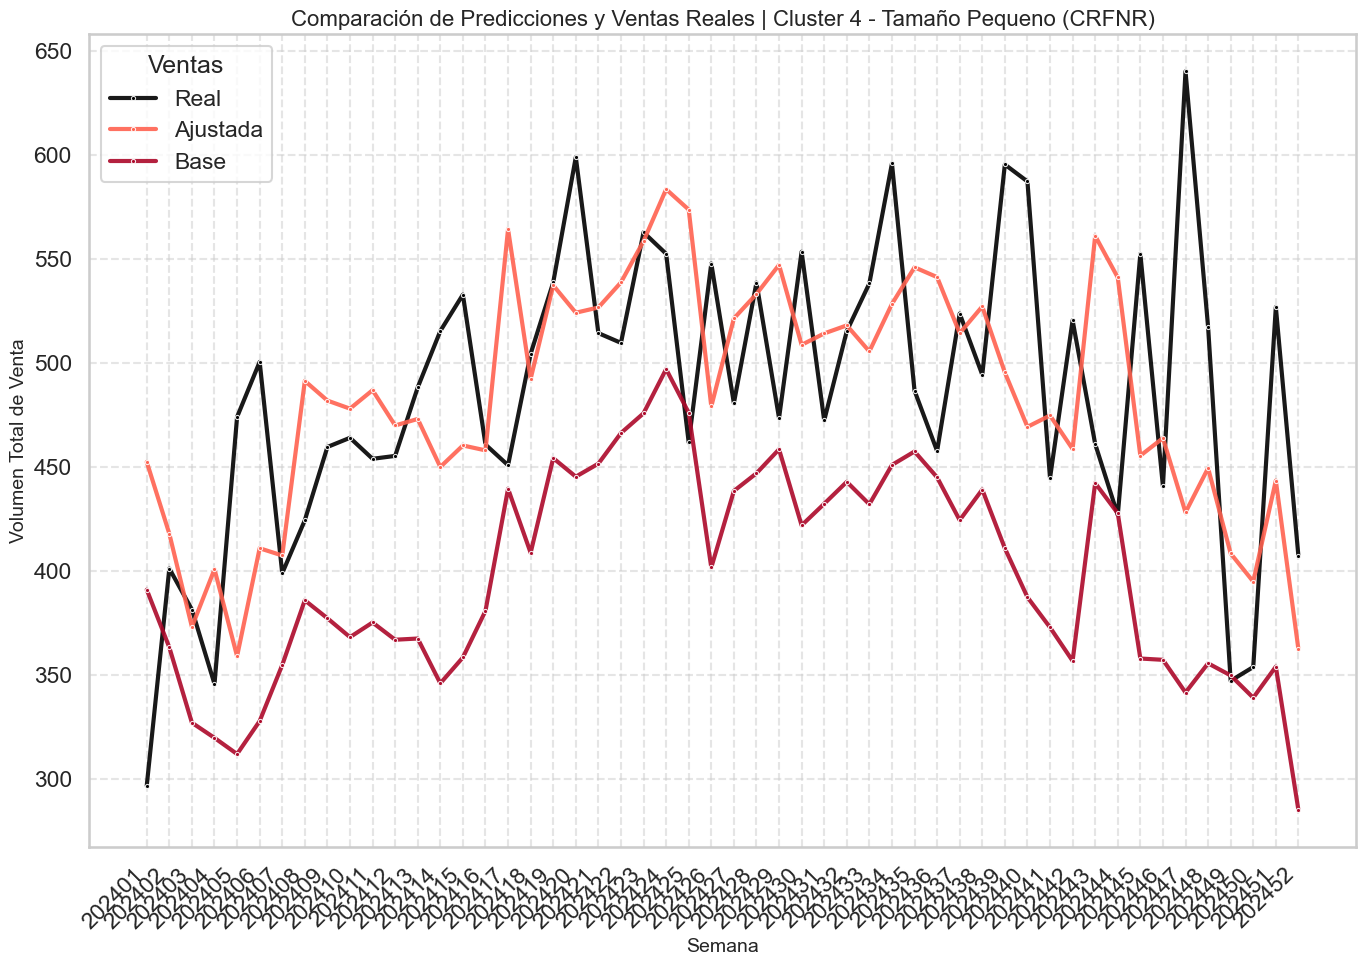

In [61]:
plot_sales_comparison_pretty(sales, product='CRFNR', cluster_id=4, client_size='Pequeno')